# Case Study - Analysis and forecasting of the sales of a certain brick and mortar retail store. The provided dataset that spans from 2000 to 2015.

### In this project, we will build different (ARIMA-based) models on the training set, whose validity and accuracy will be examined on the test set. The optimal model is the one that minimizes RMSE on the test set.

## Importing Necessary Packages


In [ ]:
# Data management libraries
import numpy as np
import pandas as pd

# Data visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display

# TS analysis and forecasting libraries
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import month_plot, plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
from itertools import product
from calendar import month_abbr

# Setting the background theme and font scale for figures
sns.set_theme(style = 'darkgrid', font_scale = 1.15)
# To restrict the float value to 2 decimal places
pd.set_option('display.float_format', lambda x: '%.2f' % x)

## Auxiliary Functions

In [ ]:
# Converting month names to their abbrevations
def month_abbrev(month):
    return str(month)[0:3]

# Reprting the MAPE score
def MAPE(y_truth, y_pred):
    mape = 0
    for i in range(len(y_truth)):
        mape += np.abs(y_truth[i] - y_pred[i])/np.abs(y_truth[i])*100
    mape = mape/len(y_truth)
    return mape

# Reporting the mean absolute deviation score
def MAD(y_truth, y_pred):
    return mean_absolute_error(y_truth, y_pred)

# Reporting the RMSE score
def RMSE(y_truth, y_pred):
    return np.sqrt(mean_squared_error(y_truth, y_pred))

## Reading the Dataset

In [ ]:
# Mounting the drive
from google.colab import drive
drive.mount('/content/drive/')

# Loading the dataset
df = pd.read_csv('/content/drive/MyDrive/Python_files/Sales.csv')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
# Viewing the first and last few rows of the dataset
print('The top 5 rows of the dataset:')
display(df.head())
print('\nThe bottom 5 rows of the dataset:')
display(df.tail())

The top 5 rows of the dataset:


,RetailSales
0,2585
1,3368
2,3210
3,3111
4,3756



The bottom 5 rows of the dataset:


,RetailSales
182,1818
183,2262
184,2612
185,2967
186,3179


In [ ]:
# Shortening the name of retail sales column
df.rename(columns = {'RetailSales': 'Sales'}, inplace = True)

# Creating timestamp and setting it as an index
dates = pd.date_range(start = '1/1/2000', periods = df.shape[0], freq = 'M')
df['Date'] = dates
df.set_index(keys = 'Date', inplace = True) 

# Creating separate year and month columns
df['Year'] = df.index.year
df['Month'] = df.index.month_name()
df['Month'] = df['Month'].apply(month_abbrev)
df.head()

,Sales,Year,Month
Date,,,
2000-01-31,2585,2000,Jan
2000-02-29,3368,2000,Feb
2000-03-31,3210,2000,Mar
2000-04-30,3111,2000,Apr
2000-05-31,3756,2000,May


## Exploratory Data Analysis

### Statistical Description

In [ ]:
# Converting month and year into categorical variables
df['Year'] = pd.Categorical(df['Year'])
df['Month'] = pd.Categorical(df['Month'])

In [ ]:
# Numerical variables
print('Statistical summary of numerical variables')
df.describe(include = np.number).T

# Categorical variables
print('Statistical summary of categorical variables')
df.describe(include = 'category').T

Statistical summary of numerical variables
Statistical summary of categorical variables


,count,unique,top,freq
Year,187,16,2000,12
Month,187,12,Apr,16


In [ ]:
# Converting year back into an integer
df['Year'] = df['Year'].astype(int)
print('Variable data types:')
display(df.info()) 

Variable data types:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 187 entries, 2000-01-31 to 2015-07-31
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   Sales   187 non-null    int64   
 1   Year    187 non-null    int64   
 2   Month   187 non-null    category
dtypes: category(1), int64(2)
memory usage: 5.0 KB


None

### Plotting the Time Series Along With Mean and Median




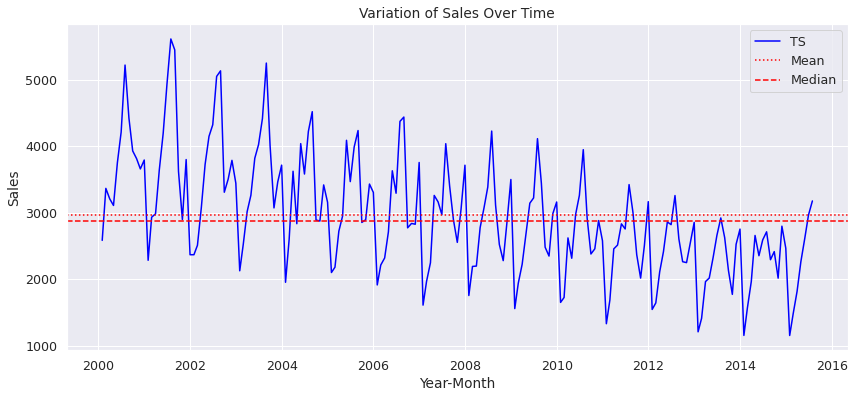

In [ ]:
plt.figure(figsize = (14, 6));
plt.plot(df.index, df.Sales, color = 'blue');
plt.axhline(df.Sales.mean(), color = 'red', linestyle = ':');
plt.axhline(df.Sales.median(), color = 'red', linestyle = '--');
plt.legend(['TS', 'Mean', 'Median'], loc = 'upper right');
plt.xlabel('Year-Month');
plt.ylabel('Sales');
plt.title('Variation of Sales Over Time');

### Annual Distribution of Sales

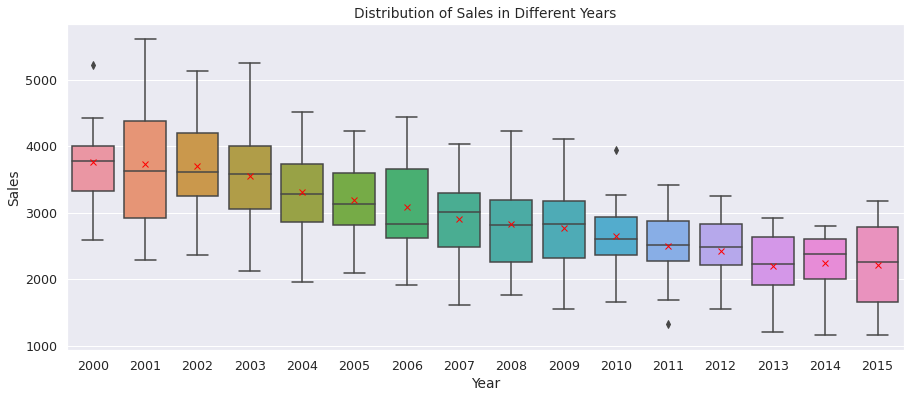

In [ ]:
plt.figure(figsize = (15, 6));
sns.boxplot(data = df, x = 'Year', y = 'Sales', showmeans = True, meanprops = 
            {'marker': 'x', 'markerfacecolor': 'red', 'markeredgecolor': 'red', 'markersize': '5.5'});
plt.title('Distribution of Sales in Different Years');

### Monthly Distribution of Sales

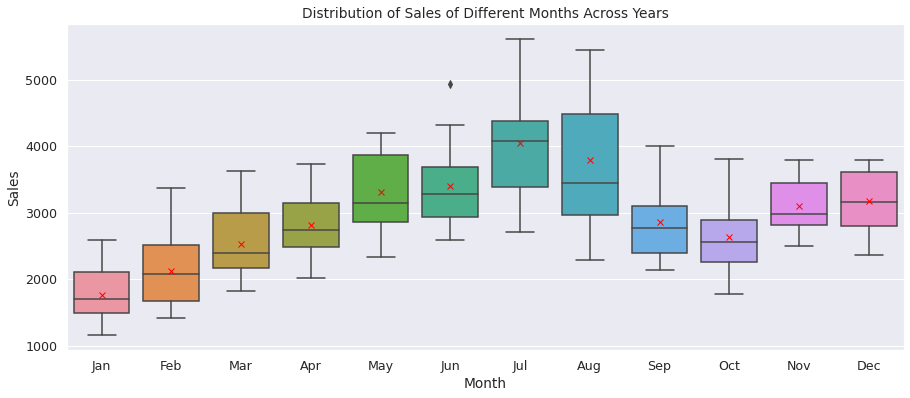

In [ ]:
plt.figure(figsize = (15, 6));
sns.boxplot(data = df, x = 'Month', y = 'Sales', showmeans = True, order = month_abbr[1:13],
            meanprops = {'marker': 'x', 'markerfacecolor': 'red', 'markeredgecolor': 'red', 'markersize': '5.5'});
plt.title('Distribution of Sales of Different Months Across Years');

### Spread and Average of Monthly Sales Across Different Years

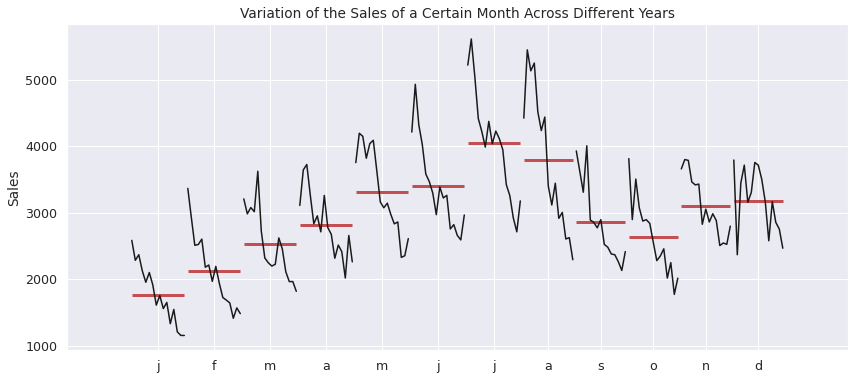

In [ ]:
from pylab import rcParams
rcParams['figure.figsize'] = 14, 6
month_plot(df['Sales'], ylabel = 'Sales');
plt.title('Variation of the Sales of a Certain Month Across Different Years');
plt.show();

### Monthly Sales Across Different Years 

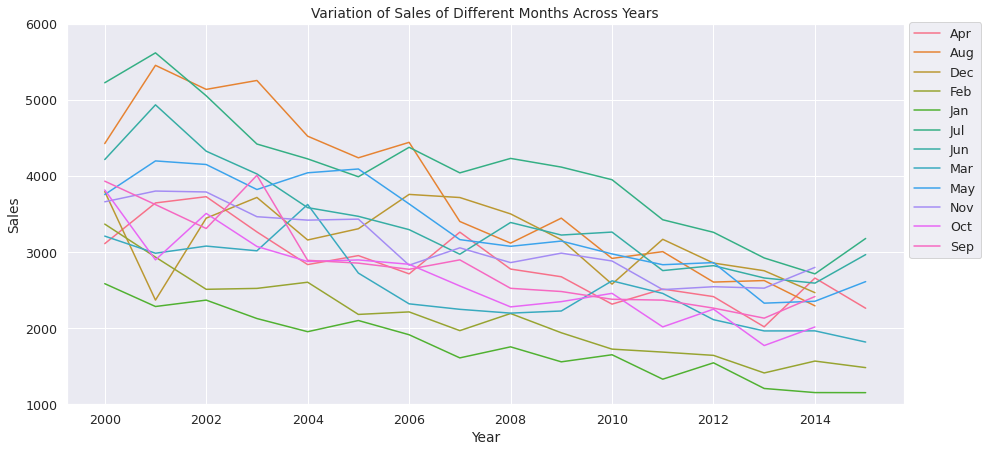

In [ ]:
plt.figure(figsize = (15, 7));
sns.lineplot(data = df, x = 'Year', y = 'Sales', hue = 'Month');
plt.ylim(1000, 6000);
plt.legend(bbox_to_anchor = [1.1, 1.02]);
plt.title('Variation of Sales of Different Months Across Years');

### Changes of Monthly Sales Across the Whole Dataset

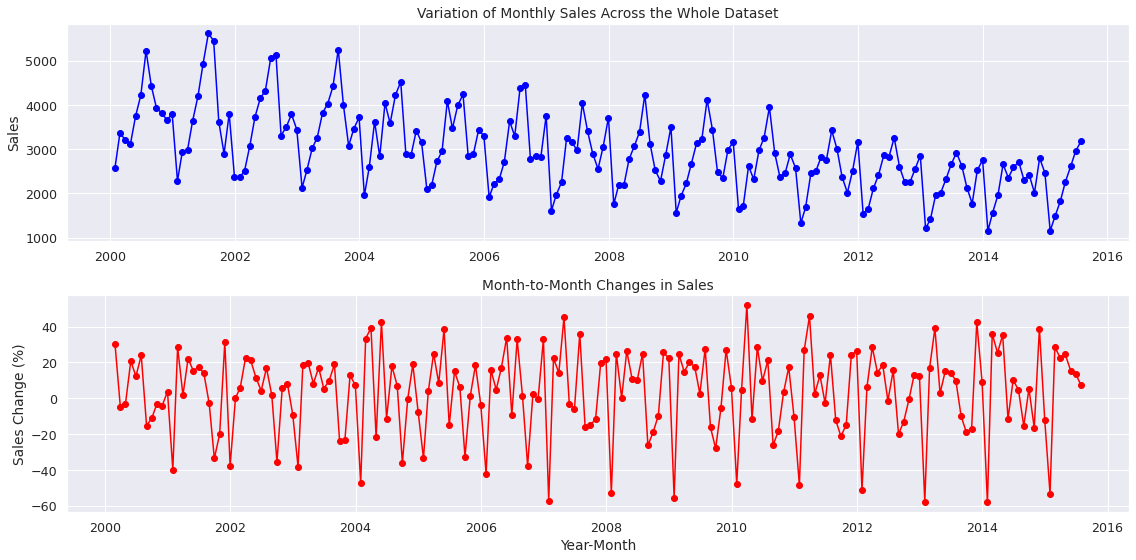

In [ ]:
plt.figure(figsize = (16, 8));
plt.subplot(211);
plt.plot(df['Sales'], color = 'blue', marker = 'o');
plt.title('Variation of Monthly Sales Across the Whole Dataset');
plt.ylabel('Sales');
plt.subplot(212);
plt.plot(df['Sales'].pct_change()*100, color = 'red', marker = 'o');
plt.title('Month-to-Month Changes in Sales');
plt.ylabel('Sales Change (%)');
plt.xlabel('Year-Month');
plt.tight_layout();

#### Observations:

There's a declining trend in sales, which is even more edident in the percentage change plot.

### Time Series Decomposition

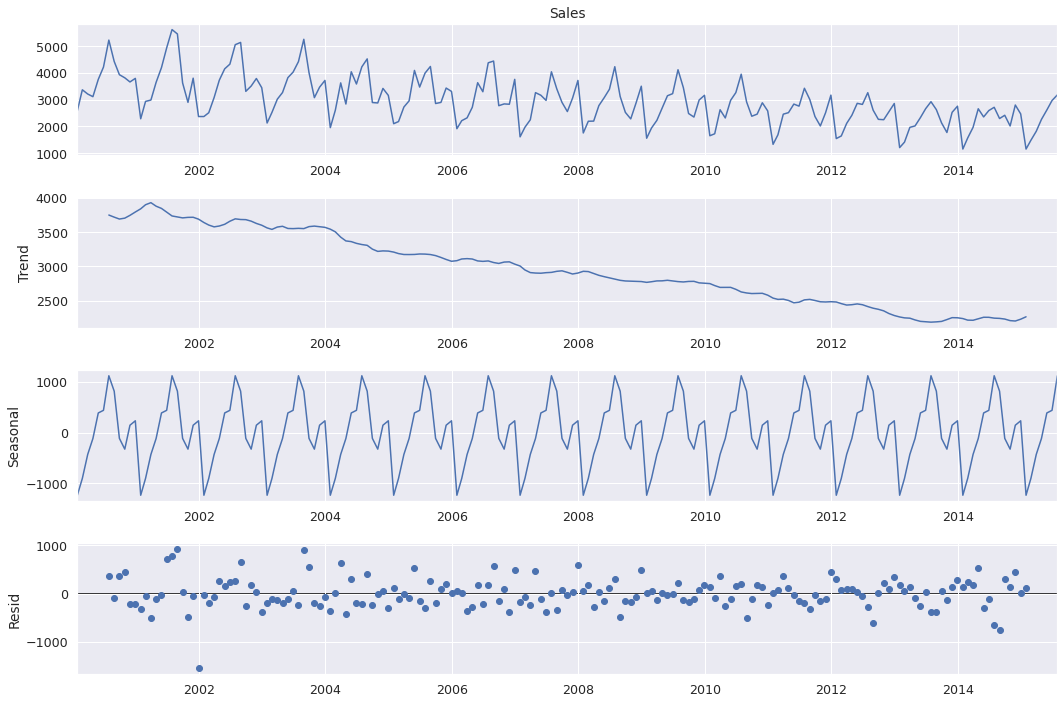

In [ ]:
rcParams['figure.figsize'] = 15, 10
sales_decomposed = seasonal_decompose(df['Sales'], model = 'additive');
sales_decomposed.plot();
plt.show();

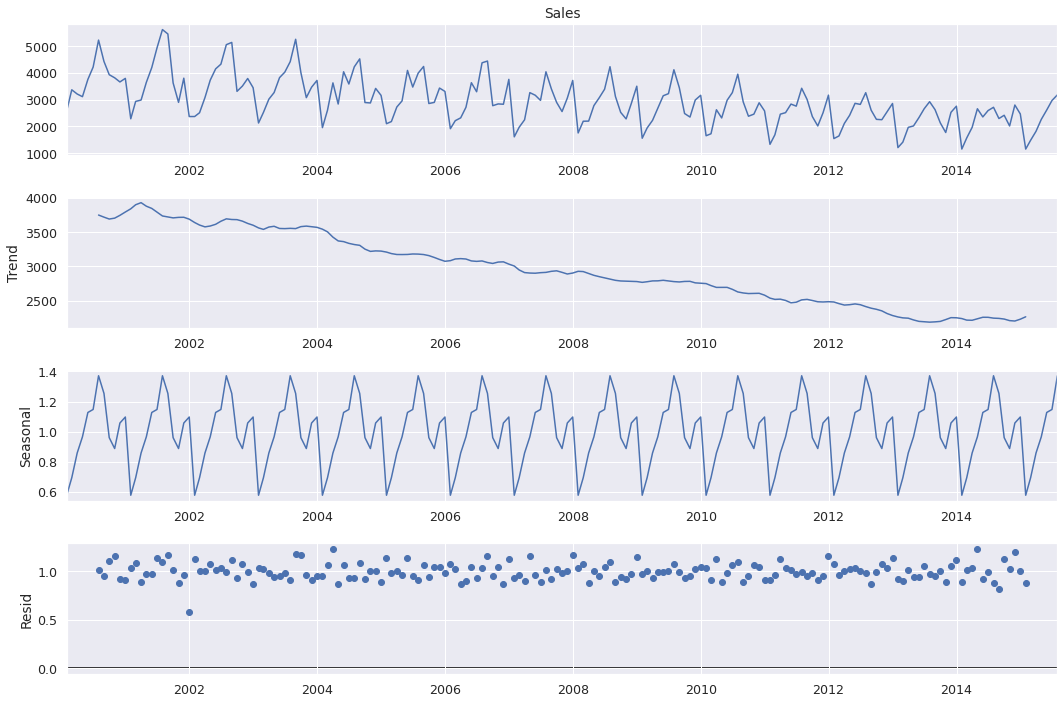

In [ ]:
rcParams['figure.figsize'] = 15, 10
sales_decomposed = seasonal_decompose(df['Sales'], model = 'multiplicative');
sales_decomposed.plot();
plt.show();

#### Observations:

The multiplicative decomposition reveals less of a pattern, and its residuals are more concentrated around their average value (1), so it seems like the better choice.

## Time Series Forecasting

### Analysis of Time Series and AC Plots

Here, we take a look at (partial) autocorrelation function plots of the time series and will conduct appropriate statistical tests on it to understand its conditions of stationarity, in order to find a proper range for the parameters of ARIMA and SARIMAX models.

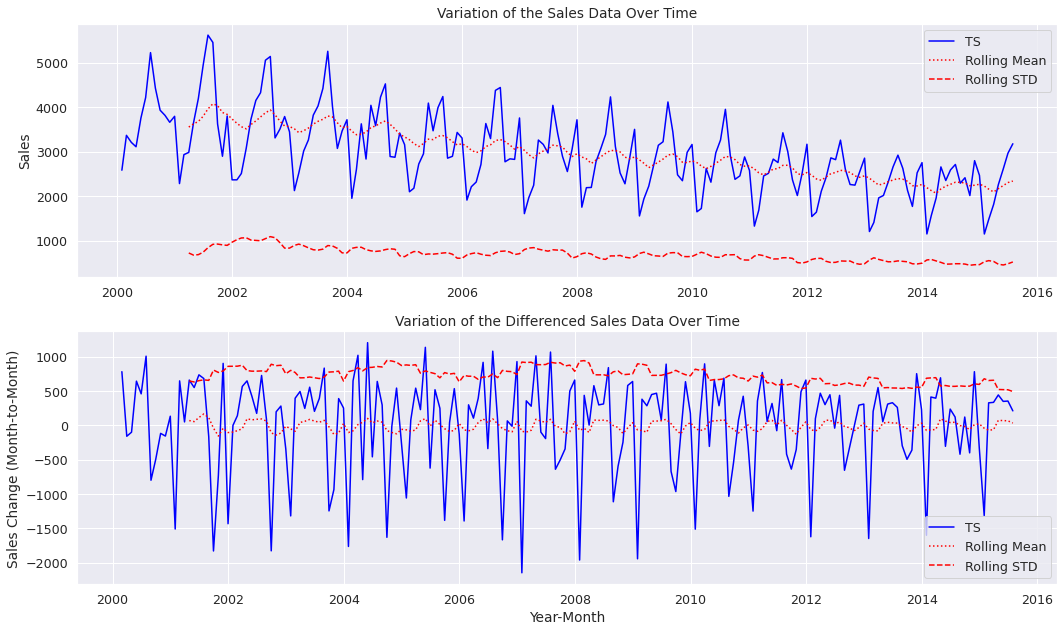

In [ ]:
plt.figure(figsize = (15, 9));
plt.subplot(211);
plt.plot(df.index, df.Sales, color = 'blue');
plt.plot(df.Sales.rolling(15).mean(), color = 'red', linestyle = ':');
plt.plot(df.Sales.rolling(15).std(ddof = 0), color = 'red', linestyle = '--');
plt.legend(['TS', 'Rolling Mean', 'Rolling STD'], loc = 'upper right');
plt.ylabel('Sales');
plt.title('Variation of the Sales Data Over Time');
plt.subplot(212);
plt.plot(df.Sales.diff(), color = 'blue');
plt.plot(df.Sales.diff().dropna().rolling(15).mean(), color = 'red', linestyle = ':');
plt.plot(df.Sales.diff().dropna().rolling(15).std(ddof = 0), color = 'red', linestyle = '--');
plt.legend(['TS', 'Rolling Mean', 'Rolling STD'], loc = 'lower right');
plt.xlabel('Year-Month');
plt.ylabel('Sales Change (Month-to-Month)');
plt.title('Variation of the Differenced Sales Data Over Time');
plt.tight_layout();

In [ ]:
# Augmented Dickey-Fuller test on sales data to check stationarity
adf_results = adfuller(df['Sales'], regression = 'ct')
print('The result of augmented Dickey-Fuller test on the original sales data:\n')
print('test statistic =', round(adf_results[0], 4))
print('p-value =', round(adf_results[1], 4))
print('no. of lags used =', adf_results[2])
print('no. of observations used =', adf_results[3])

The result of augmented Dickey-Fuller test on the original sales data:

test statistic = -3.0935
p-value = 0.1078
no. of lags used = 13
no. of observations used = 173


In [ ]:
# Augmented Dickey-Fuller test on sales data to check stationarity
adf_results = adfuller(df['Sales'].diff().dropna(), regression = 'ct')
print('The result of augmented Dickey-Fuller test on the differenced sales data:\n')
print('test statistic =', round(adf_results[0], 4))
print('p-value =', round(adf_results[1], 4))
print('no. of lags used =', adf_results[2])
print('no. of observations used =', adf_results[3])

The result of augmented Dickey-Fuller test on the differenced sales data:

test statistic = -23.4582
p-value = 0.0
no. of lags used = 10
no. of observations used = 175


#### Observations:

*   As can be seen, the once differenced TS doesn't show much of a trend,and its rolling mean and standard deviation are more steady, while the original TS reveals a declining trend and a varying rolling mean. Therefore, in order to render the data stationary, we will take d = D = 1.

*   Furthermore, only the differenced data passes the test for stationarity, as its p-value becomes below the level of significance. On the other hand, we fail to reject the non-stationarity of the original sales data, as its p-value remains above 0.05.

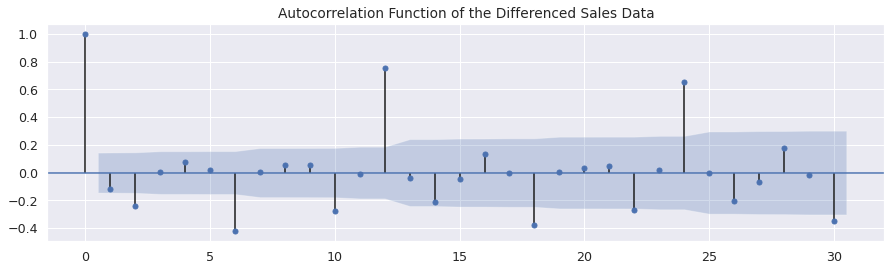

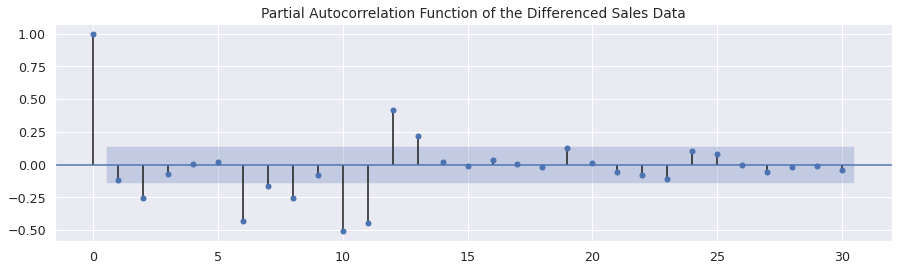

In [ ]:
rcParams['figure.figsize'] = 15, 4
plot_acf(df['Sales'].diff().dropna(), lags = 30, title = 
         'Autocorrelation Function of the Differenced Sales Data');
plt.show();
rcParams['figure.figsize'] = 15, 4
plot_pacf(df['Sales'].diff().dropna(), lags = 30, method = 'ywm', 
         title = 'Partial Autocorrelation Function of the Differenced Sales Data');
plt.show();

#### Observations:

*   According to the AC plots, both AC and partial AC get apmlified every six lags. Following this observation, we will take F = 6 in the SARIMAX model. 

*   Furthermore, we see that AC and partial AC go below the limit of statistical significance somewhere between the first and third lag. We thus choose p and q varying from 0 to 2. But since at lag = 1, both ACF and PACF are already statistically insignificant, for manual (AC-plot-based) ARIMA model, we choose p = q = 0.  

*   The autocorrelation plot reveals that, the AC of the first lag after each peak (corresponding to period or multiples of 6), has no statistical significance, indicating that Q = 0 might be the best choice, just by eye-balling the ACF plot. We also note that it's usually the third lag after each peak whose partial AC vanishes, implying that, solely by examining the PACF plot, P = 2 might be the best choice in a SARIMAX model.

*   Note that, in the SARIMAX hyperparameter search, similar to p and q, we let the values of P and Q also vary from 0 to 2. 

### Building Training and Test Sets

We keep any data from 2013 and after for testing, and the remainder for training.

In [ ]:
train = df['Sales'].loc[df['Year'] < 2013]
test  = df['Sales'].loc[df['Year'] >= 2013]

# Viewing the train and test sets
print('The first few rows of the training set:')
display(train.head(7))
print('\nThe first few rows of the test set:')
display(test.head(7))

# Shape of train and test sets
print('\nNo. of observations in the training set:', train.shape[0])
print('No. of observations in the test set:', test.shape[0])

The first few rows of the training set:


Date
2000-01-31    2585
2000-02-29    3368
2000-03-31    3210
2000-04-30    3111
2000-05-31    3756
2000-06-30    4216
2000-07-31    5225
Name: Sales, dtype: int64


The first few rows of the test set:


Date
2013-01-31    1208
2013-02-28    1412
2013-03-31    1964
2013-04-30    2018
2013-05-31    2329
2013-06-30    2660
2013-07-31    2923
Name: Sales, dtype: int64


No. of observations in the training set: 156
No. of observations in the test set: 31


### Model 1: ARIMA (Automated)

Here, we carry out a grid search over a reasonable range for the parameters of the ARIMA model, and will select the one that minimizes AIC.

In [ ]:
# Setting the range of model's hyperparameters
p = np.arange(0, 3)
q = np.arange(0, 3)
d = np.arange(1, 2)

# Making a combination of all hyperparameters
pdq = list(product(p, d, q))
pdq

[(0, 1, 0),
 (0, 1, 1),
 (0, 1, 2),
 (1, 1, 0),
 (1, 1, 1),
 (1, 1, 2),
 (2, 1, 0),
 (2, 1, 1),
 (2, 1, 2)]

In [ ]:
# Looping over all combinations of hyperparameters 
# to choose the one minimizing AIC
min_aic = 1.e18
for param in pdq:
    # Building the model with the current set of parameters
    auto_arima = ARIMA(train, order = param).fit()
    arima_aic  = auto_arima.aic
    if(arima_aic < min_aic):
        optimal_param = param
        min_aic = arima_aic
print('Optimal parameters of ARIMA based on AIC score:', optimal_param)

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so in

Optimal parameters of ARIMA based on AIC score: (2, 1, 2)


In [ ]:
# Building the model with optimal parameters
auto_arima = ARIMA(train, order = (2, 1, 2)).fit()
# Making predictions using the model
auto_arima_pred = auto_arima.get_forecast(len(test))

# Looking the at the model's summary
print(auto_arima.summary())

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                  156
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -1226.323
Date:                Fri, 23 Dec 2022   AIC                           2462.646
Time:                        03:33:56   BIC                           2477.863
Sample:                    01-31-2000   HQIC                          2468.827
                         - 12-31-2012                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2106      0.196     -1.076      0.282      -0.594       0.173
ar.L2          0.3158      0.131      2.417      0.016       0.060       0.572
ma.L1         -0.1182      0.144     -0.823      0.4

#### Observations:

*   The most important coefficient is the second coefficient of moving average.
*   Two of the coefficients aren't statistically significant.
*   The residuals are homoscedastic and independently distributed, but do not pass the test for normal distribution. 

In [ ]:
# Calculating the performance of the model
rmse_score = RMSE(test, auto_arima_pred.predicted_mean)
mad_score  = MAD(test, auto_arima_pred.predicted_mean)
mape_score  = MAPE(test, auto_arima_pred.predicted_mean)
print('The Auto ARIMA model\'s RMSE score =', round(rmse_score, 2))
print('The Auto ARIMA model\'s MAD score =', round(mad_score, 2))
print('The Auto ARIMA model\'s MAPE score =', round(mape_score, 3))

# Adding the evaluation metrics of the model to a comparison dataframe
models_compare = pd.DataFrame(columns = ['RMSE', 'MAD', 'MAPE (%)'])
models_compare.loc['Auto ARIMA', :] = [rmse_score, mad_score, mape_score]

The Auto ARIMA model's RMSE score = 700.3
The Auto ARIMA model's MAD score = 522.89
The Auto ARIMA model's MAPE score = 32.235


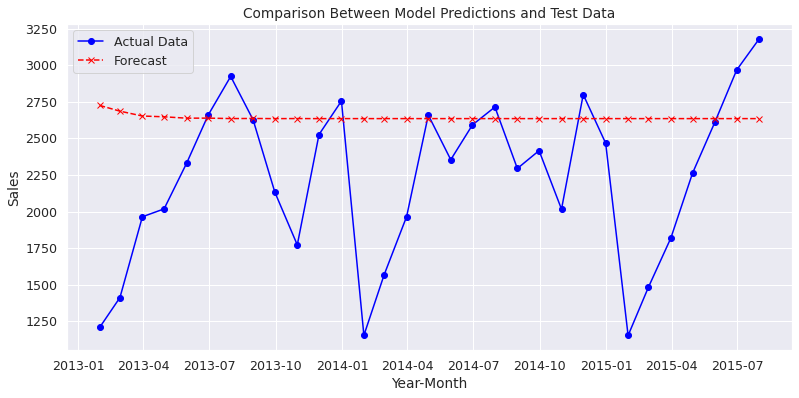

In [ ]:
# Plotting the model predictions vs. actual data
plt.figure(figsize = (13, 6));
plt.plot(test.index, test.values, color = 'blue', marker = 'o');
plt.plot(test.index, auto_arima_pred.predicted_mean, color = 'red', linestyle = '--', marker = 'x');
plt.legend(['Actual Data', 'Forecast'], loc = 'upper left');
plt.xlabel('Year-Month');
plt.ylabel('Sales');
plt.title('Comparison Between Model Predictions and Test Data');

### Model 2: ARIMA (Manual)

In this model, the ARIMA hyperparameters are chosen by carefully  inspecting the AC plots. According to observations from the AC plots, the best eye-balled combination of parameters for an ARIMA model is (p, d, q) = (0, 1, 0). 

In [ ]:
# Building the model with optimal parameters
manual_arima = ARIMA(train, order = (0, 1, 0)).fit()
# Making predictions using the model
manual_arima_pred = manual_arima.get_forecast(len(test))

# Looking the at the model's summary
print(manual_arima.summary())

                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                  156
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -1245.920
Date:                Fri, 23 Dec 2022   AIC                           2493.839
Time:                        03:33:58   BIC                           2496.883
Sample:                    01-31-2000   HQIC                          2495.075
                         - 12-31-2012                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2       5.58e+05   5.86e+04      9.522      0.000    4.43e+05    6.73e+05
Ljung-Box (L1) (Q):                   2.37   Jarque-Bera (JB):                25.41
Prob(Q):                              0.12   Pr

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


#### Observations:

Again the residuals of the model are independent and homoscedastic, but not normally distributed.

In [ ]:
# Calculating the performance of the model
rmse_score = RMSE(test, manual_arima_pred.predicted_mean)
mad_score  = MAD(test, manual_arima_pred.predicted_mean)
mape_score  = MAPE(test, manual_arima_pred.predicted_mean)
print('The Manual ARIMA model\'s RMSE score =', round(rmse_score, 2))
print('The Manual ARIMA model\'s MAD score =', round(mad_score, 2))
print('The Manual ARIMA model\'s MAPE score =', round(mape_score, 3))

# Adding the evaluation metrics of the model to a comparison dataframe
models_compare.loc['Manual ARIMA', :] = [rmse_score, mad_score, mape_score]

The Manual ARIMA model's RMSE score = 842.14
The Manual ARIMA model's MAD score = 669.1
The Manual ARIMA model's MAPE score = 40.221


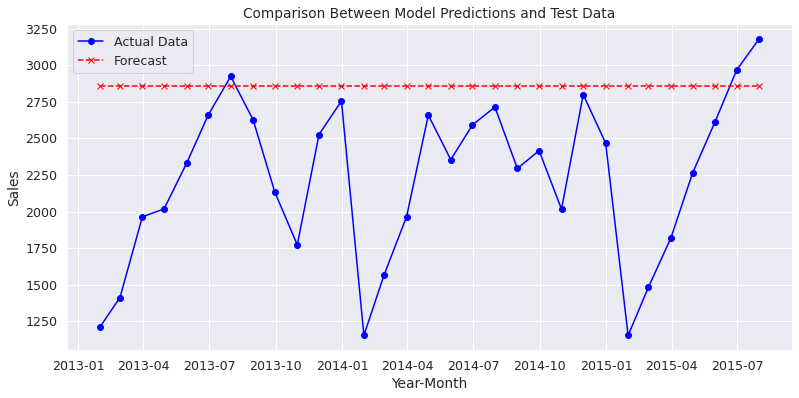

In [ ]:
# Plotting the model predictions vs. actual data
plt.figure(figsize = (13, 6));
plt.plot(test.index, test.values, color = 'blue', marker = 'o');
plt.plot(test.index, manual_arima_pred.predicted_mean, color = 'red', linestyle = '--', marker = 'x');
plt.legend(['Actual Data', 'Forecast'], loc = 'upper left');
plt.xlabel('Year-Month');
plt.ylabel('Sales');
plt.title('Comparison Between Model Predictions and Test Data');

#### Observations:

Unsurprisingly, since for this model p = q = 0, it doesn't capture any trend, and its predictions are just some constant values.

### Model 3: SARIMAX (Automated)

*   Here, we carry out a grid search over a reasonable range for the parameters of the SARIMAX model, and will select the one that minimizes AIC.

*   In order to find a proper D-value, we first need to examine whether differencing the data over one period (= 6 data points) would render a stationary dataset. In that case, D = 0 is a good choice. Otherwise, further differencing of the periodic data would be necessary. Let's first make sure of this before proceeding to building the model.  

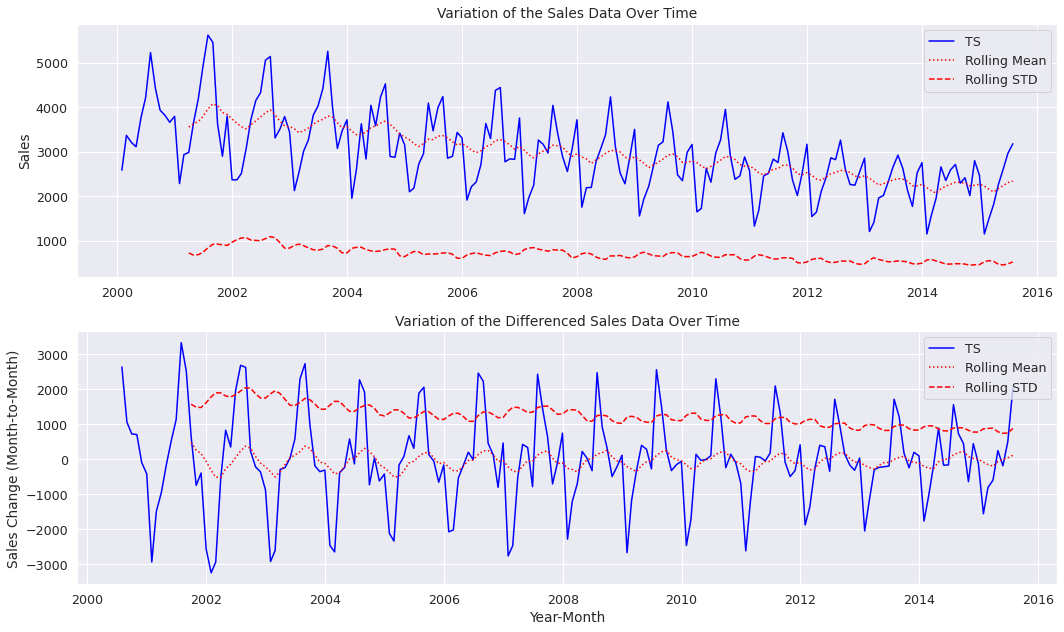

In [ ]:
plt.figure(figsize = (15, 9));
plt.subplot(211);
plt.plot(df.index, df.Sales, color = 'blue');
plt.plot(df.Sales.rolling(15).mean(), color = 'red', linestyle = ':');
plt.plot(df.Sales.rolling(15).std(ddof = 0), color = 'red', linestyle = '--');
plt.legend(['TS', 'Rolling Mean', 'Rolling STD'], loc = 'upper right');
plt.ylabel('Sales');
plt.title('Variation of the Sales Data Over Time');
plt.subplot(212);
plt.plot(df.Sales.diff(6), color = 'blue');
plt.plot(df.Sales.diff(6).dropna().rolling(15).mean(), color = 'red', linestyle = ':');
plt.plot(df.Sales.diff(6).dropna().rolling(15).std(ddof = 0), color = 'red', linestyle = '--');
plt.legend(['TS', 'Rolling Mean', 'Rolling STD'], loc = 'upper right');
plt.xlabel('Year-Month');
plt.ylabel('Sales Change (Month-to-Month)');
plt.title('Variation of the Differenced Sales Data Over Time');
plt.tight_layout();

In [ ]:
# Augmented Dickey-Fuller test on sales data to check stationarity
adf_results = adfuller(df['Sales'].diff(6).dropna(), regression = 'ct')
print('The result of augmented Dickey-Fuller test on the sales data differenced over one period:\n')
print('test statistic =', round(adf_results[0], 4))
print('p-value =', round(adf_results[1], 4))
print('no. of lags used =', adf_results[2])
print('no. of observations used =', adf_results[3])

The result of augmented Dickey-Fuller test on the sales data differenced over one period:

test statistic = -41.7696
p-value = 0.0
no. of lags used = 5
no. of observations used = 175


#### Observations:

Looking at the time series of the differenced data and the result of the ADF test, we can certainly conclude that, in comparison with the original TS, differencing over one period has certainly detrended the data and has made it stationary. Therefore, we will use D = 0 in our SARIMA models.

In [ ]:
# Setting the range of model's hyperparameters
p = np.arange(0, 3)
q = np.arange(0, 3)
d = np.arange(1, 2)
P = np.arange(0, 3)
Q = np.arange(0, 3)
D = np.arange(0, 1)
F = np.arange(6, 7)

# Making a combination of all hyperparameters
pdq = list(product(p, d, q))
PDQF = list(product(P, D, Q, F))
print('Parameters of the ARIMA component of the SARIMA model:')
print(np.array(pdq))
print('\nParameters of the seasonal component of the SARIMA model:')
print(np.array(PDQF))

Parameters of the ARIMA component of the SARIMA model:
[[0 1 0]
 [0 1 1]
 [0 1 2]
 [1 1 0]
 [1 1 1]
 [1 1 2]
 [2 1 0]
 [2 1 1]
 [2 1 2]]

Parameters of the seasonal component of the SARIMA model:
[[0 0 0 6]
 [0 0 1 6]
 [0 0 2 6]
 [1 0 0 6]
 [1 0 1 6]
 [1 0 2 6]
 [2 0 0 6]
 [2 0 1 6]
 [2 0 2 6]]


In [ ]:
# Suppressing warnings
import warnings
warnings.filterwarnings('ignore')

# Looping over all combinations of hyperparameters 
# to choose the one minimizing AIC
min_aic = 1.e18
for arima_param in pdq:
    for seasonal_param in PDQF:
      # Building the model with the current set of parameters
      auto_sarima = SARIMAX(train, order = arima_param, seasonal_order = seasonal_param,
                            enforce_invertibility = False, enforce_stationarity = False).fit(maxiter = 1000)
      arima_aic = auto_sarima.aic
      if(arima_aic < min_aic):
          optimal_arima_param = arima_param
          optimal_seasonal_param = seasonal_param
          min_aic = arima_aic
print('Optimal parameters of the ARIMA component of the SARIMA model based on AIC score:', 
      optimal_arima_param)
print('Optimal parameters of the seasonal component of the SARIMA model based on AIC score:', 
      optimal_seasonal_param)

Optimal parameters of the ARIMA component of the SARIMA model based on AIC score: (0, 1, 2)
Optimal parameters of the seasonal component of the SARIMA model based on AIC score: (2, 0, 2, 6)


In [ ]:
# Building the model with optimal parameters
auto_sarima = SARIMAX(train, order = optimal_arima_param, seasonal_order = optimal_seasonal_param,
                      enforce_invertibility = False, enforce_stationarity = False).fit(maxiter = 1000)
# Making predictions using the model
auto_sarima_pred = auto_sarima.get_forecast(len(test))

# Looking the at the model's summary
print(auto_sarima.summary())

                                     SARIMAX Results                                     
Dep. Variable:                             Sales   No. Observations:                  156
Model:             SARIMAX(0, 1, 2)x(2, 0, 2, 6)   Log Likelihood               -1010.977
Date:                           Fri, 23 Dec 2022   AIC                           2035.954
Time:                                   03:34:34   BIC                           2056.545
Sample:                               01-31-2000   HQIC                          2044.322
                                    - 12-31-2012                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9809      0.132     -7.449      0.000      -1.239      -0.723
ma.L2         -0.0191      0.083     -0.230

#### Observations:

*   The residuals of the model are independent, but not normally distributed or homoscedastic. 
*   The second coefficient of the seasonality autoregressive term is the most important term in the present SARIMA model. 

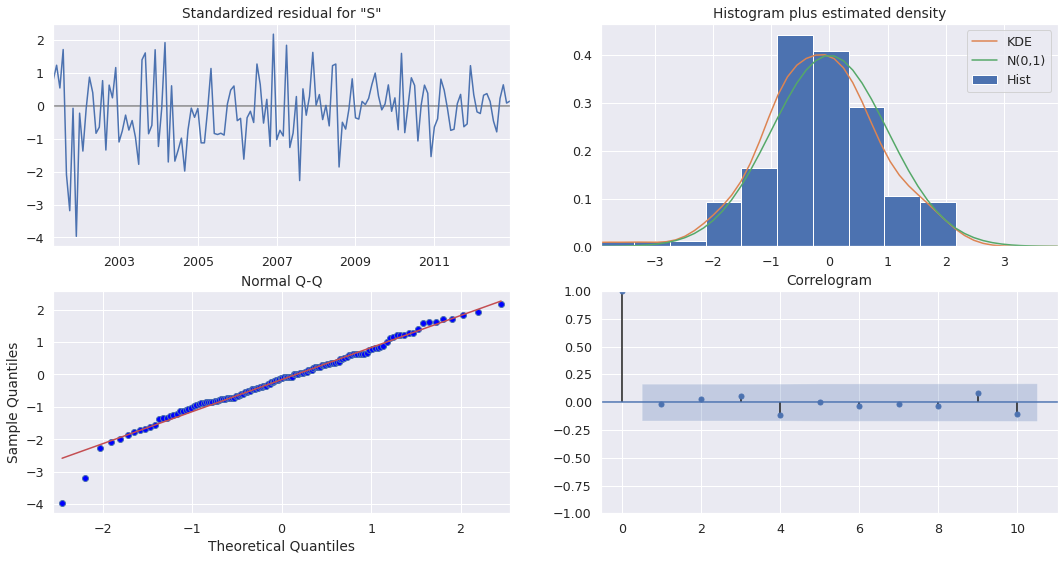

In [ ]:
# Statistical plots of the residuals
rcParams['figure.figsize'] = 18, 9
auto_sarima.plot_diagnostics();
plt.show();

#### Observations:

However the residuals didn't pass the test for normality, their PDF and Q-Q plot show that they're actually very close to a Gaussian distribution. 

In [ ]:
# Calculating the performance of the model
rmse_score = RMSE(test, auto_sarima_pred.predicted_mean)
mad_score  = MAD(test, auto_sarima_pred.predicted_mean)
mape_score  = MAPE(test, auto_sarima_pred.predicted_mean)
print('The Auto SARIMA model\'s RMSE score =', round(rmse_score, 2))
print('The Auto SARIMA model\'s MAD score =', round(mad_score, 2))
print('The Auto SARIMA model\'s MAPE score =', round(mape_score, 3))

# Adding the evaluation metrics of the model to a comparison dataframe
models_compare.loc['Auto SARIMA', :] = [rmse_score, mad_score, mape_score]

The Auto SARIMA model's RMSE score = 240.07
The Auto SARIMA model's MAD score = 188.04
The Auto SARIMA model's MAPE score = 8.681


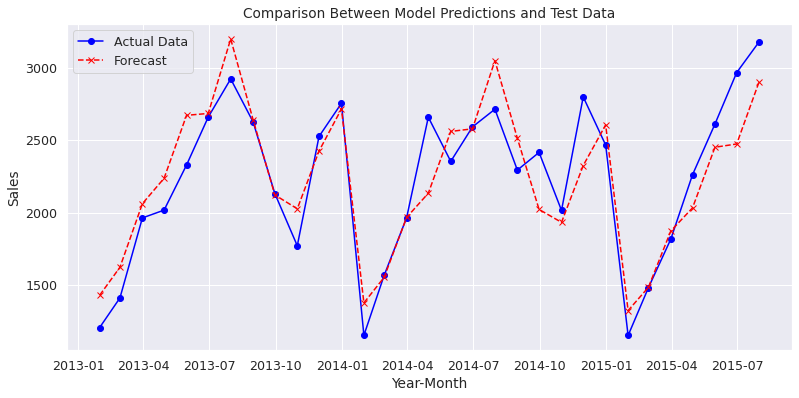

In [ ]:
# Plotting the model predictions vs. actual data
plt.figure(figsize = (13, 6));
plt.plot(test.index, test.values, color = 'blue', marker = 'o');
plt.plot(test.index, auto_sarima_pred.predicted_mean, color = 'red', linestyle = '--', marker = 'x');
plt.legend(['Actual Data', 'Forecast'], loc = 'upper left');
plt.xlabel('Year-Month');
plt.ylabel('Sales');
plt.title('Comparison Between Model Predictions and Test Data');

### Model 4: SARIMAX (Manual)

In this model, the SARIMAX hyperparameters are chosen by carefully  inspecting the AC plots. According to observations from the AC plots, the best eye-balled combination of parameters for an ARIMA model is (p, d, q)(P, D, Q)F = (0, 1, 0)(2, 0, 0)6. 

In [ ]:
# Building the model with optimal parameters
manual_sarima = SARIMAX(train, order = (0, 1, 0), seasonal_order = (2, 0, 0, 6),
                        enforce_invertibility = False, enforce_stationarity = False).fit(maxiter = 1000)
# Making predictions using the model
manual_sarima_pred = manual_sarima.get_forecast(len(test))

# Looking the at the model's summary
print(manual_sarima.summary())

                                     SARIMAX Results                                     
Dep. Variable:                             Sales   No. Observations:                  156
Model:             SARIMAX(0, 1, 0)x(2, 0, 0, 6)   Log Likelihood               -1083.111
Date:                           Fri, 23 Dec 2022   AIC                           2172.221
Time:                                   03:34:36   BIC                           2181.110
Sample:                               01-31-2000   HQIC                          2175.833
                                    - 12-31-2012                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L6       -0.1082      0.072     -1.507      0.132      -0.249       0.033
ar.S.L12       0.7202      0.059     12.300

#### Observations:

*   The first seasonal autoregressive component isn't statistically significant.
*   The second seasonal autoregressive component is the most important part of the model.  

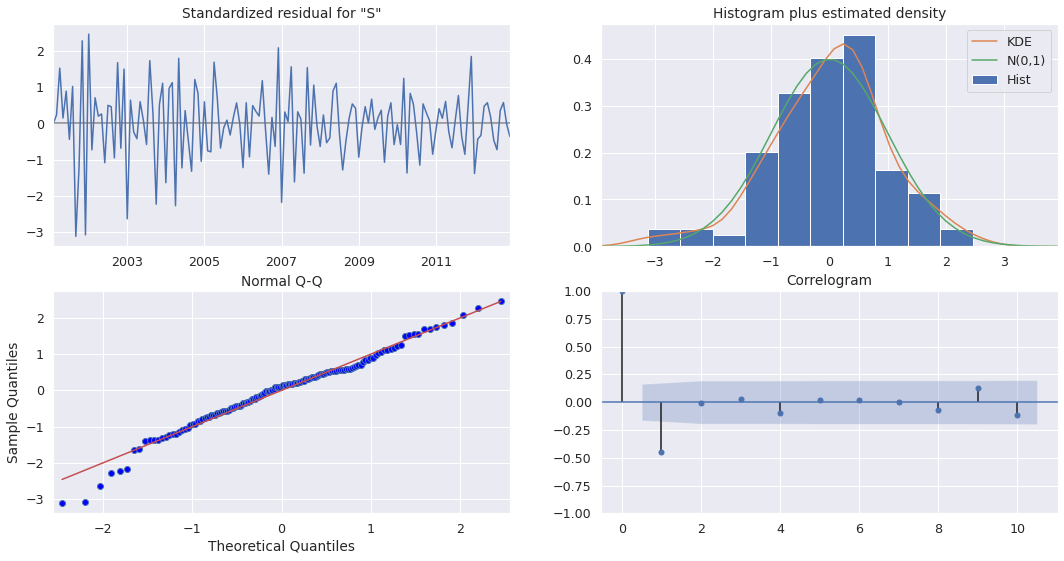

In [ ]:
# Statistical plots of the residuals
rcParams['figure.figsize'] = 18, 9
manual_sarima.plot_diagnostics();
plt.show();

#### Observations:

*   However the residuals are almost normally distributed, they're not fully independent. Look at the AC at lag = 1 which isn't statistically zero. 

In [ ]:
# Calculating the performance of the model
rmse_score = RMSE(test, manual_sarima_pred.predicted_mean)
mad_score  = MAD(test, manual_sarima_pred.predicted_mean)
mape_score  = MAPE(test, manual_sarima_pred.predicted_mean)
print('The Manual SARIMA model\'s RMSE score =', round(rmse_score, 2))
print('The Manual SARIMA model\'s MAD score =', round(mad_score, 2))
print('The Manual SARIMA model\'s MAPE score =', round(mape_score, 3))

# Adding the evaluation metrics of the model to a comparison dataframe
models_compare.loc['Manual SARIMA', :] = [rmse_score, mad_score, mape_score]

The Manual SARIMA model's RMSE score = 322.93
The Manual SARIMA model's MAD score = 274.45
The Manual SARIMA model's MAPE score = 14.963


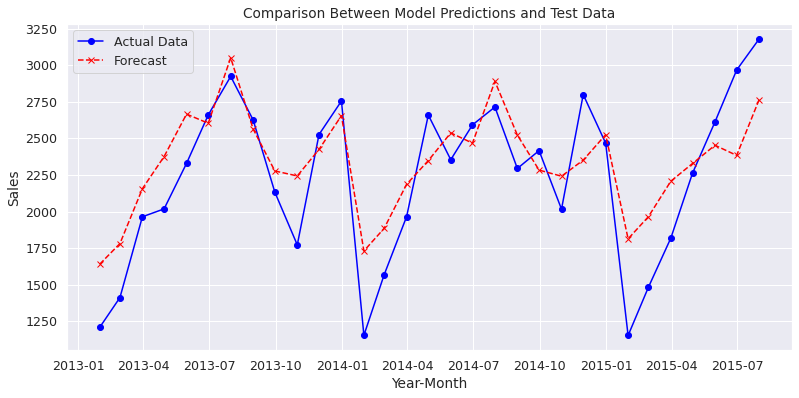

In [ ]:
# Plotting the model predictions vs. actual data
plt.figure(figsize = (13, 6));
plt.plot(test.index, test.values, color = 'blue', marker = 'o');
plt.plot(test.index, manual_sarima_pred.predicted_mean, color = 'red', linestyle = '--', marker = 'x');
plt.legend(['Actual Data', 'Forecast'], loc = 'upper left');
plt.xlabel('Year-Month');
plt.ylabel('Sales');
plt.title('Comparison Between Model Predictions and Test Data');

## Selecting the Best Model 

In [ ]:
models_compare.sort_values(by = 'RMSE')

,RMSE,MAD,MAPE (%)
Auto SARIMA,240.07,188.04,8.68
Manual SARIMA,322.93,274.45,14.96
Auto ARIMA,700.30,522.89,32.24
Manual ARIMA,842.14,669.10,40.22


#### Observations: 

Expectedly, SARIMA model, whose parameters have been captured via an extensive grid search performs better than the three other models. The large errors of the ARIMA models are mainly attributed to the their inability in capturing the seasonal variations.   

## Prediction of Future via the Best Model

We use the full data to predict 17 months into the future (until the end of 2016).

In [ ]:
# Rebuilding the best model on the full data
best_model = SARIMAX(df['Sales'], order = (0, 1, 2), seasonal_order = (2, 0, 2, 6),
                     enforce_invertibility = False, enforce_stationarity = False).fit(maxiter = 1000)

# Looking the at the best model's summary
print(best_model.summary())

                                     SARIMAX Results                                     
Dep. Variable:                             Sales   No. Observations:                  187
Model:             SARIMAX(0, 1, 2)x(2, 0, 2, 6)   Log Likelihood               -1227.004
Date:                           Fri, 23 Dec 2022   AIC                           2468.008
Time:                                   03:34:38   BIC                           2490.000
Sample:                               01-31-2000   HQIC                          2476.932
                                    - 07-31-2015                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9537      0.116     -8.256      0.000      -1.180      -0.727
ma.L2         -0.0463      0.073     -0.631

#### Observations:

The statistical significance of the model parameters hasn't changed, compared to the one built only on the training data.

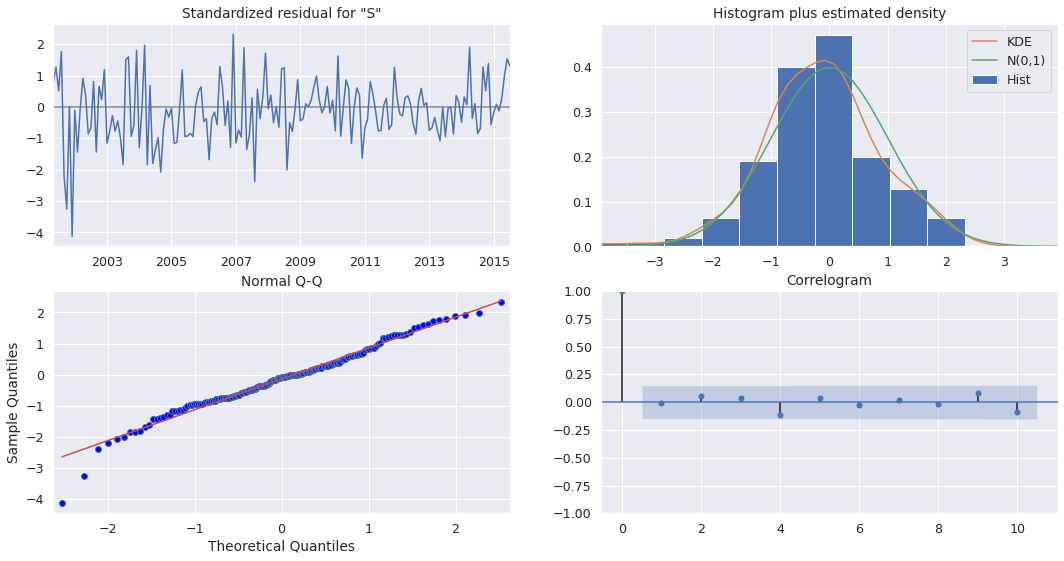

In [ ]:
# Statistical plots of the residuals
rcParams['figure.figsize'] = 18, 9
best_model.plot_diagnostics();
plt.show();

#### Observations:

The distribution of residuals is not too far from normal, and they're certainly independent from each other (but not homoscedastic).

In [ ]:
# Making predictions for the 17 next months
future_pred = best_model.get_forecast(17)
future_pred_mean = future_pred.predicted_mean
# The lower an upper bounds of 95% confidence intervals of predictions
future_pred_lb = future_pred.conf_int()['lower Sales']
future_pred_ub = future_pred.conf_int()['upper Sales']

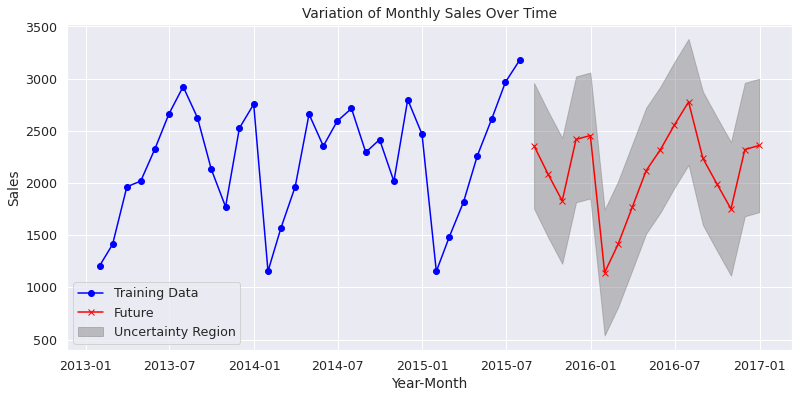

In [ ]:
# Plotting the model predictions vs. actual data
plt.figure(figsize = (13, 6));
plt.plot(test.index, test.values, color = 'blue', marker = 'o');
plt.plot(future_pred_mean, color = 'red', marker = 'x');
plt.fill_between(x = future_pred_mean.index, y1 = future_pred_lb, y2 = future_pred_ub, 
                 color = 'grey', alpha = 0.45);
plt.legend(['Training Data', 'Future', 'Uncertainty Region'], loc = 'lower left');
plt.xlabel('Year-Month');
plt.ylabel('Sales');
plt.title('Variation of Monthly Sales Over Time');